<a href="https://colab.research.google.com/github/tohpedo/wikibot/blob/main/transformers_latest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Environment Set Up


In [1]:
#check if Google Pro is running. From Google Pro Documentation
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')


  gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!
Tue Nov 23 14:07:22 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    38W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
    

TRAIN

In [2]:
#install hugging face
!pip install pytorch-pretrained-bert pytorch-nlp pytorch_transformers
!pip install folium

#import required packages

import pandas as pd
import glob
import io
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_transformers import BertTokenizer, BertConfig, BertModel
from pytorch_transformers import AdamW, BertForQuestionAnswering
from tqdm import tqdm, trange


In [3]:
#import helper functions for squad dataset
!wget 'https://raw.githubusercontent.com/nlpyang/pytorch-transformers/master/examples/utils_squad.py'
!wget 'https://raw.githubusercontent.com/nlpyang/pytorch-transformers/master/examples/utils_squad_evaluate.py'

from utils_squad import (read_squad_examples, convert_examples_to_features,
                         RawResult, write_predictions,
                         RawResultExtended, write_predictions_extended)
from utils_squad_evaluate import EVAL_OPTS, main as evaluate_on_squad, plot_pr_curve

--2021-11-23 14:07:30--  https://raw.githubusercontent.com/nlpyang/pytorch-transformers/master/examples/utils_squad.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 41529 (41K) [text/plain]
Saving to: ‘utils_squad.py.12’

utils_squad.py.12   100%[===================>]  40.56K  --.-KB/s    in 0.003s  

2021-11-23 14:07:31 (11.7 MB/s) - ‘utils_squad.py.12’ saved [41529/41529]

--2021-11-23 14:07:31--  https://raw.githubusercontent.com/nlpyang/pytorch-transformers/master/examples/utils_squad_evaluate.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting respons

In [4]:
#check if GPU is available
def isGPUAvailable():
  #check if GPU is available 
  gpu = tf.test.gpu_device_name()
  if gpu != '/device:GPU:0':
    print('No GPU available')
  else:
    print('GPU is available')

isGPUAvailable()

GPU is available


In [5]:
#mount colab drive
from google.colab import drive
drive.mount('/content/drive/')
!ls

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
drive			    utils_squad_evaluate.py.4  utils_squad.py.12
__pycache__		    utils_squad_evaluate.py.5  utils_squad.py.2
sample_data		    utils_squad_evaluate.py.6  utils_squad.py.3
utils_squad_evaluate.py     utils_squad_evaluate.py.7  utils_squad.py.4
utils_squad_evaluate.py.1   utils_squad_evaluate.py.8  utils_squad.py.5
utils_squad_evaluate.py.10  utils_squad_evaluate.py.9  utils_squad.py.6
utils_squad_evaluate.py.11  utils_squad.py	       utils_squad.py.7
utils_squad_evaluate.py.12  utils_squad.py.1	       utils_squad.py.8
utils_squad_evaluate.py.2   utils_squad.py.10	       utils_squad.py.9
utils_squad_evaluate.py.3   utils_squad.py.11


In [6]:
#set random seeds
np.random.seed(1234)
torch.manual_seed(1234)

In [7]:
#read in training data

train_data_file = '/content/drive/My Drive/train-v2.0.json'
train_data_raw = read_squad_examples(input_file=train_data_file, is_training=True, version_2_with_negative=True)

In [8]:
#inspecting first records
sample_record = train_data_raw[:1]
print(sample_record)

[qas_id: 56be85543aeaaa14008c9063, question_text: When did Beyonce start becoming popular?, doc_tokens: [Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".], start_position: 39, end_position: 42]


In [9]:
#take first 75,000 rows for training due to RAM limitation
train_data_raw = train_data_raw[:1000]
train_data = pd.DataFrame.from_records([vars(record) for record in train_data_raw])

print("Number of records for training: " + str(len(train_data)))


Number of records for training: 1000


In [10]:
#Set model parameters
#not enough memory for batch size 64
batch_size = 32
doc_stride = 128
max_seq_length = 256
max_query_length = 64
bert_base = 1

if bert_base == 1:
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
else:
    tokenizer = BertTokenizer.from_pretrained('bert-large-uncased')

model_features = convert_examples_to_features(examples=train_data_raw,
                                        tokenizer=tokenizer,
                                        max_seq_length=max_seq_length,
                                        doc_stride=doc_stride,
                                        max_query_length=max_query_length,
                                        is_training=True)
torch.save(model_features, "/content/drive/My Drive/bert_train")


In [11]:
# Convert to Tensors and build dataset
all_input_ids = torch.tensor([f.input_ids for f in model_features], dtype=torch.long)
all_input_mask = torch.tensor([f.input_mask for f in model_features], dtype=torch.long)
all_segment_ids = torch.tensor([f.segment_ids for f in model_features], dtype=torch.long)
all_cls_index = torch.tensor([f.cls_index for f in model_features], dtype=torch.long)
all_p_mask = torch.tensor([f.p_mask for f in model_features], dtype=torch.float)

all_start_positions = torch.tensor([f.start_position for f in model_features], dtype=torch.long)
all_end_positions = torch.tensor([f.end_position for f in model_features], dtype=torch.long)
dataset = TensorDataset(all_input_ids, all_input_mask, all_segment_ids,
                        all_start_positions, all_end_positions,
                        all_cls_index, all_p_mask)

In [12]:
random_sampler = RandomSampler(dataset)
train_dataloader = DataLoader(dataset, sampler=random_sampler, batch_size=batch_size, drop_last=True)

In [13]:
def to_list(tensor):
    return tensor.detach().cpu().tolist()

In [14]:
checkpoints = sorted(glob.glob('/content/drive/My Drive/checkpoint*-[0-9]*'))

In [15]:
global_step = 0
train_loss_set = []
tr_loss = 0.0

if bert_base == 1:
    model = BertForQuestionAnswering.from_pretrained('bert-base-uncased')
else:
    model = BertForQuestionAnswering.from_pretrained('bert-large-uncased')



model.cuda()

BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_

OPTIMIZER


In [16]:
param_optimizer = list(model.named_parameters())


In [17]:
#initialize AdamW optimizer for fine tuning
num_epochs=10
lr = 0.001
#lr = 0.01
eps=0.00000001
no_decay = ['bias', 'LayerNorm.weight']
param_grouped = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]
optimizer = AdamW(param_grouped, lr=lr, eps=eps)

Run training

In [18]:
#Train model

# specify GPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

print("  Number of Examples = %d" % len(dataset))
print("  Number of Epochs = %d" % num_epochs)
print("  Batch size = %d" % batch_size)
model.zero_grad()
train_iterator = trange(num_epochs, desc="Epoch")

for _ in train_iterator:
    epoch_iterator = tqdm(train_dataloader, desc="Iteration")
    for step, batch in enumerate(epoch_iterator):
      if step < global_step + 1:
        continue

      model.train()
      batch = tuple(t.to(device) for t in batch)

      inputs = {'input_ids':       batch[0],
                'attention_mask':  batch[1], 
                'token_type_ids':  batch[2],  
                'start_positions': batch[3], 
                'end_positions':   batch[4]}

      outputs = model(**inputs)

      loss = outputs[0]
      train_loss_set.append(loss)
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

      tr_loss += loss.item()
      optimizer.step()
      model.zero_grad()
      global_step += 1
    
      if global_step % 1000 == 0:
        print("Train loss: {}".format(tr_loss/global_step))
        output_dir = '/content/drive/My Drive/checkpoint-{}'.format(global_step)
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
        model_to_save.save_pretrained(output_dir)
        torch.save(torch.tensor(train_loss_set), os.path.join(output_dir, 'training_loss.pt'))
        print("Saving model checkpoint to %s" % output_dir)

  Number of Examples = 1202
  Number of Epochs = 10
  Batch size = 32


Iteration:   0%|          | 0/37 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/pytorch_transformers/optimization.py:166: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:1050.)
  exp_avg.mul_(beta1).add_(1.0 - beta1, grad)

Iteration: 100%|██████████| 37/37 [00:00<00:00, 1776.52it/s]

Iteration: 100%|██████████| 37/37 [00:00<00:00, 1806.48it/s]

Iteration: 100%|██████████| 37/37 [00:00<00:00, 1793.68it/s]

Iteration: 100%|██████████| 37/37 [00:00<00:00, 1981.17it/s]

Iteration: 100%|██████████| 37/37 [00:00<00:00, 1554.11it/s]

Iteration: 100%|██████████| 37/37 [00:00<00:00, 1810.40it/s]

Epoch: 100%|██████████| 10/10 [00:30<00:00,  3.05s/it]


In [19]:
output_dir = '/content/drive/My Drive/checkpoint-final'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)

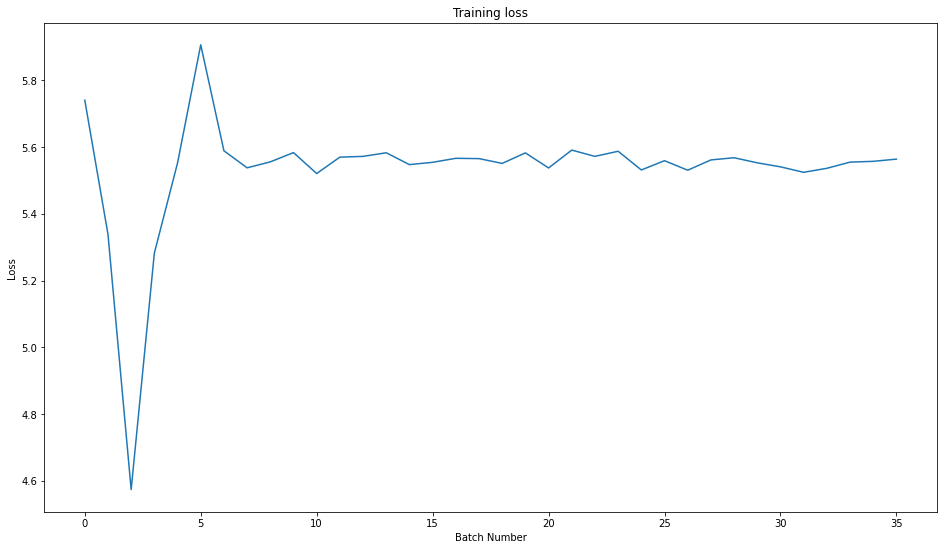

In [20]:
plt.figure(figsize=(16,9))
plt.title("Training loss")
plt.xlabel("Batch Number")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

In [25]:
test_data = '/content/drive/My Drive/dev-v2.0.json'
cached_output = '/content/drive/My Drive/cached_output/'
val_examples = read_squad_examples(input_file=test_data,
                                is_training=False,
                                version_2_with_negative=True
                                )
# Cache features for faster loading
model_features = convert_examples_to_features(examples=val_examples,
                                      tokenizer=tokenizer,
                                      max_seq_length=max_seq_length,
                                      doc_stride=doc_stride,
                                      max_query_length=max_query_length,
                                      is_training=False)

#torch.save(model_features, cached_output)

In [ ]:
# Convert to Tensors and build dataset
all_input_ids = torch.tensor([f.input_ids for f in model_features], dtype=torch.long)
all_input_mask = torch.tensor([f.input_mask for f in model_features], dtype=torch.long)
all_segment_ids = torch.tensor([f.segment_ids for f in model_features], dtype=torch.long)
all_cls_index = torch.tensor([f.cls_index for f in model_features], dtype=torch.long)
all_p_mask = torch.tensor([f.p_mask for f in model_features], dtype=torch.float)

all_example_index = torch.arange(all_input_ids.size(0), dtype=torch.long)
dataset = TensorDataset(all_input_ids, all_input_mask, all_segment_ids,
                        all_example_index, all_cls_index, all_p_mask)

In [ ]:
seq_sampler = SequentialSampler(dataset)
validation_dataloader = DataLoader(dataset, sampler=seq_sampler, batch_size=batch_size, drop_last=True)

TEST MODEL

In [ ]:
def evaluate(model, tokenizer):
  print("***** Running evaluation *****")
  print("  Num examples = %d" % len(dataset))
  print("  Batch size = %d" % batch_size)
  all_results = []
  predict_file = '/content/drive/My Drive/dev-v2.0.json'
  for batch in tqdm(validation_dataloader, desc="Evaluating", miniters=100, mininterval=5.0):
    model.eval()
    batch = tuple(t.to(device) for t in batch)
    with torch.no_grad():
      inputs = {'input_ids':      batch[0],
                'attention_mask': batch[1],
                'token_type_ids': batch[2]
                }
      example_indices = batch[3]
      outputs = model(**inputs)

    for i, example_index in enumerate(example_indices):
      eval_feature = features[example_index.item()]
      unique_id = int(eval_feature.unique_id)

      result = RawResult(unique_id    = unique_id,
                         start_logits = to_list(outputs[0][i]),
                         end_logits   = to_list(outputs[1][i]))
      all_results.append(result)

  # Compute predictions
  output_prediction_file = "/content/drive/My Drive/predictions.json"
  output_nbest_file = "/content/drive/My Drive/nbest_predictions.json"
  output_null_log_odds_file = "/content/drive/My Drive/null_odds.json"
  output_dir = "/content/drive/My Drive/predict_results"

  write_predictions(val_examples, features, all_results, 10,
                  30, True, output_prediction_file,
                  output_nbest_file, output_null_log_odds_file, False,
                  True, 0.0)

  # Evaluate with the official SQuAD script
  evaluate_options = EVAL_OPTS(data_file=predict_file,
                               pred_file=output_prediction_file,
                               na_prob_file=output_null_log_odds_file,
                               out_image_dir=None)
  results = evaluate_on_squad(evaluate_options)
  return results

In [ ]:
results = evaluate(model, tokenizer)